In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import scipy.sparse as sp
import time
import gget
from scipy.spatial.distance import cdist
import scipy
from scipy.stats import zscore
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from adjustText import adjust_text

import anndata as an
import scanpy as sc
import scanpy.external as sce
import rapids_singlecell as rsc
import scvi

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import linregress, spearmanr

import cupy as cp
from cuml.manifold import TSNE
from cuml.decomposition import PCA

from matplotlib import gridspec
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap

sc.settings.verbosity = 2

# load data

In [2]:
%%time
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/new_processed/new_scvelo.h5ad"
adata = sc.read_h5ad(fpath)
adata

CPU times: user 351 ms, sys: 8.89 s, total: 9.24 s
Wall time: 1min 52s


AnnData object with n_obs × n_vars = 15317 × 23434
    obs: 'batch', 'barcoded_phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'velocity_pseudotime', 'G1_velocity_pseudotime', 'G2M_velocity_pseudotime', 'mean_velocity_pseudotime'
    var: 'gene_id', 'gene_type', 

In [3]:
# new cluster names
new_grouping = {  
    'R2': ['C1'],
    'R1': ['C2'],
    'C5': ['C3'],
    'C4': ['C4'],
    'R3': ['C5'],
}

# Invert the mapping: from old -> new
reverse_map = {old: new for new, olds in new_grouping.items() for old in olds}

adata.obs['cluster_str'] = adata.obs['cluster_str'].astype(str)

# create new grouping
adata.obs['cluster'] = adata.obs['cluster_str'].map(reverse_map)
adata.obs['cluster'] = adata.obs['cluster'].astype('category')

adata.obs['cluster_str'] = adata.obs['cluster_str'].astype('category')

print(adata.obs['cluster'].value_counts())

# define custom palette
clusters = adata.obs['cluster'].cat.categories
print(clusters)

cluster_colors = {
    'R1': '#02A679',
    'R2': '#D55E00',
    'R3': '#F9CF86',
    'C4': '#FFA9E6',
    'C5': '#5C5D9E',
}

adata.uns['cluster_colors'] = [cluster_colors[c] for c in clusters]

cluster
C4    4612
R2    4343
C5    3852
R1    1986
R3     524
Name: count, dtype: int64
Index(['C4', 'C5', 'R1', 'R2', 'R3'], dtype='object')


In [4]:
low = '#131317' # dark
mid = '#3B80EB' # blue
high = '#F2D123' # yellow

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap",
    [(0.0, low), (0.15, low), (0.5, mid), (0.85, high), (1.0, high)]
)

# correlations

In [5]:
fit_thresh = 0.3
velo_thresh = 0.1

mask = (
    (adata.var['velocity_genes']) &
    (adata.var['fit_r2'] > fit_thresh) &
    (adata.var['velocity_r2'] > velo_thresh)
)

layer = 'spliced'

pt = adata.obs['mean_velocity_pseudotime']
X = adata[:, mask].layers[layer].toarray()

cors = []
pvals = []
for i in range(X.shape[1]):
    corr, pval = spearmanr(X[:, i], pt)
    cors.append(corr)
    pvals.append(pval)

cors = np.array(cors)
pvals = np.array(pvals)

# FDR correction
reject, pvals_fdr, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

gene_names = adata.var_names[mask]
cors_df = pd.DataFrame({
    'gene': gene_names,
    'correlation': cors,
    'p_value': pvals,
    'p_value_fdr': pvals_fdr,
    'significant': reject
})

print(cors_df.shape)

cors_df = cors_df[cors_df['significant']]

print(cors_df.shape)
cors_df.head()

(355, 5)
(329, 5)


,gene,correlation,p_value,p_value_fdr,significant
0,ABTB2,0.197462,1.771678e-134,3.699681e-134,True
1,ACKR4,-0.208331,8.445510e-150,1.850714e-149,True
2,ACTB,-0.118671,3.680836e-49,5.731126e-49,True
3,ACTG1,-0.129107,6.258413e-58,9.962944e-58,True
4,ADAM12,-0.139617,1.574884e-67,2.576424e-67,True


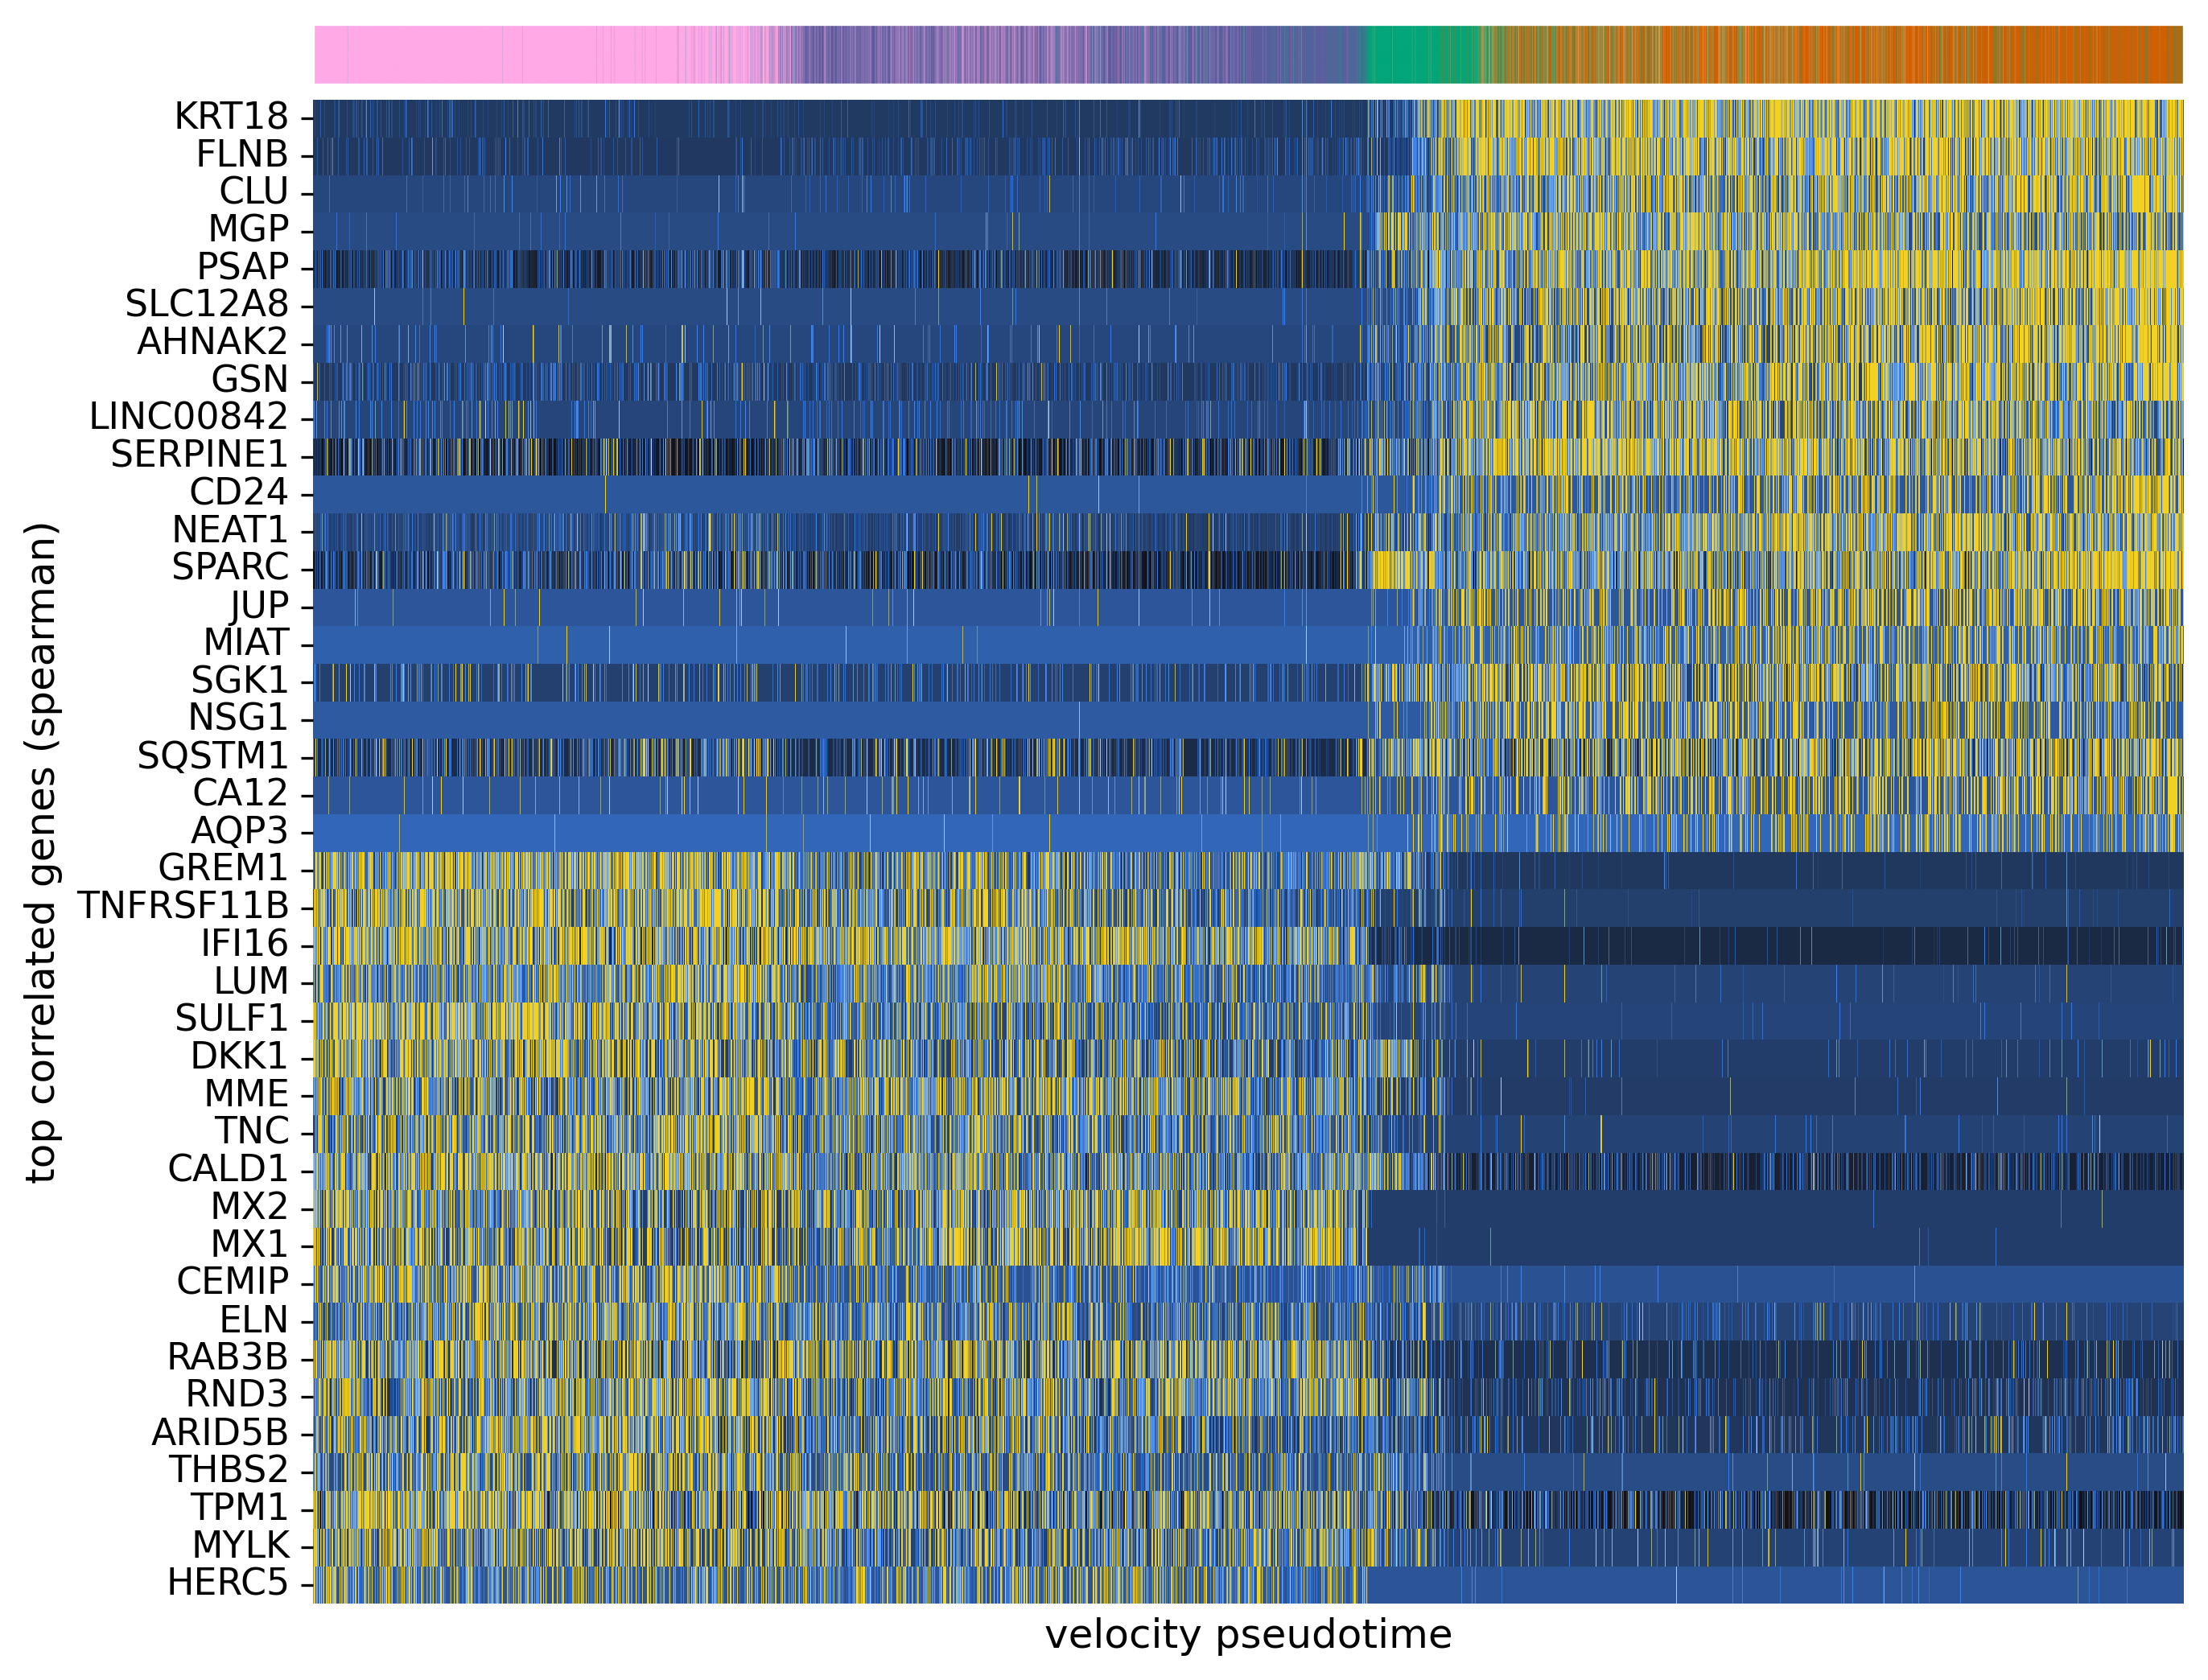

In [6]:
# get top correlated genes
top_n_genes = 20

top_pos = cors_df.sort_values(by='correlation', ascending=False)['gene'].head(top_n_genes).tolist()
top_neg = cors_df.sort_values(by='correlation', ascending=True)['gene'].head(top_n_genes).tolist()
selected_genes = top_pos + top_neg


cell_order = adata.obs.sort_values("mean_velocity_pseudotime").index
n_cells = len(cell_order)

adata.X = adata.layers[layer].copy()

expr = adata[cell_order, selected_genes].X
if not isinstance(expr, np.ndarray):
    expr = expr.toarray()

# z-score expression
expr_z = zscore(expr, axis=0)

# get bar for cluster order
clusters = adata.obs.loc[cell_order, 'cluster']

# mapping: category → color
cluster_colors = dict(zip(
    adata.obs['cluster'].cat.categories,
    adata.uns['cluster_colors']
))

# convert cluster labels to colors for each cell in order
col_colors = clusters.map(cluster_colors).to_numpy()
rgba_colors = np.array([to_rgba(c) for c in col_colors])


fig = plt.figure(figsize=(10, 8.5), dpi=300)

gs = gridspec.GridSpec(
    2, 1, 
    height_ratios=[0.4, 10],   # small top bar, big heatmap
    hspace=0.02                 # small spacing
)

# --- Top colorbar axis (tiny horizontal strip) ---
ax_color = fig.add_subplot(gs[0])

ax_color.imshow(rgba_colors[np.newaxis, :, :], aspect='auto')
ax_color.set_xlim(0, n_cells)
ax_color.set_xticks([])
ax_color.set_yticks([])
for spine in ax_color.spines.values():
    spine.set_edgecolor('white')

ax_heat = fig.add_subplot(gs[1])

sns.heatmap(
    expr_z.T,
    cmap=custom_cmap,
    xticklabels=False,
    yticklabels=selected_genes,
    vmin=-1.5,
    vmax=1.5,
    cbar=False,
    ax=ax_heat,
)
ax_heat.set_yticklabels(ax_heat.get_yticklabels(), fontsize=11)
ax_heat.set_xlabel("velocity pseudotime", fontsize=12)
ax_heat.set_ylabel("top correlated genes (spearman)", fontsize=12)

plt.tight_layout()
plt.show()

## unspliced

In [27]:
fit_thresh = 0.3
velo_thresh = 0.1

mask = (
    (adata.var['velocity_genes']) &
    (adata.var['fit_r2'] > fit_thresh) &
    (adata.var['velocity_r2'] > velo_thresh)
)

layer = 'unspliced'

pt = adata.obs['mean_velocity_pseudotime']
X = adata[:, mask].layers[layer].toarray()

cors = []
pvals = []
for i in range(X.shape[1]):
    corr, pval = spearmanr(X[:, i], pt)
    cors.append(corr)
    pvals.append(pval)

cors = np.array(cors)
pvals = np.array(pvals)

# FDR correction
reject, pvals_fdr, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

gene_names = adata.var_names[mask]
cors_df_unspliced = pd.DataFrame({
    'gene': gene_names,
    'correlation': cors,
    'p_value': pvals,
    'p_value_fdr': pvals_fdr,
    'significant': reject
})

print(cors_df_unspliced.shape)

cors_df_unspliced = cors_df_unspliced[cors_df_unspliced['significant']]

print(cors_df_unspliced.shape)
cors_df_unspliced.head()

(355, 5)
(319, 5)


,gene,correlation,p_value,p_value_fdr,significant
0,ABTB2,0.552894,0.000000e+00,0.000000e+00,True
1,ACKR4,-0.223973,2.009289e-173,6.256996e-173,True
2,ACTB,-0.259080,2.130768e-233,8.595712e-233,True
3,ACTG1,-0.274027,5.967125e-262,2.647912e-261,True
4,ADAM12,-0.103002,2.103771e-37,3.539520e-37,True


In [29]:
unspliced_pos = cors_df_unspliced[cors_df_unspliced['correlation'] > 0].copy()
unspliced_pos = unspliced_pos.sort_values(by='correlation', ascending=False)
unspliced_neg = cors_df_unspliced[cors_df_unspliced['correlation'] < 0].copy()
unspliced_neg = unspliced_neg.sort_values(by='correlation', ascending=True)
print(f"N pos unsplied: {unspliced_pos['gene'].nunique()}")
print(f"N neg unsplied: {unspliced_neg['gene'].nunique()}")

spliced_pos = cors_df[cors_df['correlation'] > 0].copy()
spliced_pos = spliced_pos.sort_values(by='correlation', ascending=False)
spliced_neg = cors_df[cors_df['correlation'] < 0].copy()
spliced_neg = spliced_neg.sort_values(by='correlation', ascending=True)
print(f"N pos splied: {spliced_pos['gene'].nunique()}")
print(f"N neg splied: {spliced_neg['gene'].nunique()}")

spliced_neg.head()

N pos unsplied: 146
N neg unsplied: 173
N pos splied: 97
N neg splied: 232


,gene,correlation,p_value,p_value_fdr,significant
142,GREM1,-0.754374,0.0,0.0,True
326,TNFRSF11B,-0.734394,0.0,0.0,True
160,IFI16,-0.726806,0.0,0.0,True
201,LUM,-0.699012,0.0,0.0,True
315,SULF1,-0.678530,0.0,0.0,True


In [37]:
n = 15
# top pos
print("Top spliced POS:")
print(spliced_pos['gene'].tolist()[:n])
print("Top unspliced POS:")
print(unspliced_pos['gene'].tolist()[:n])

# top neg
print("Top spliced NEG:")
print(spliced_neg['gene'].tolist()[:n])
print("Top unspliced NEG:")
print(unspliced_neg['gene'].tolist()[:n])

Top spliced POS:
['KRT18', 'FLNB', 'CLU', 'MGP', 'PSAP', 'SLC12A8', 'AHNAK2', 'GSN', 'LINC00842', 'SERPINE1', 'CD24', 'NEAT1', 'SPARC', 'JUP', 'MIAT']
Top unspliced POS:
['FLNB', 'IGFL2-AS1', 'CLU', 'SERPINE1', 'KCNMA1', 'SLC12A8', 'HIP1', 'LINC00842', 'NEBL', 'ABTB2', 'SGK1', 'MORC3', 'KRT18', 'NEAT1', 'GAS7']
Top spliced NEG:
['GREM1', 'TNFRSF11B', 'IFI16', 'LUM', 'SULF1', 'DKK1', 'MME', 'TNC', 'CALD1', 'MX2', 'MX1', 'CEMIP', 'ELN', 'RAB3B', 'RND3']
Top unspliced NEG:
['DCN', 'CALD1', 'MAML2', 'SLIT2', 'SULF1', 'KIF26B', 'IFIT2', 'PRRX1', 'IFI6', 'FMN2', 'PDZRN3', 'ADAMTS6', 'CEMIP', 'MYLK', 'NEGR1']


In [ ]:
# pos overlap?

t = 0.2


In [34]:
# any switches?
# none from spliced_pos to unspliced_neg
splice_to_unsplice = list(set(spliced_neg['gene'].tolist()) & set(unspliced_pos['gene'].tolist()))
print(len(splice_to_unsplice))
splice_to_unsplice

33


['FANCI',
 'CKAP2L',
 'KIF4A',
 'CENPK',
 'NUSAP1',
 'CENPI',
 'ASPM',
 'TPX2',
 'PBK',
 'KIF15',
 'DTL',
 'KRT34',
 'MND1',
 'NSD2',
 'BUB1B',
 'SHCBP1',
 'MIS18BP1',
 'NDC80',
 'NEIL3',
 'KIF23',
 'KIF20B',
 'BRCA1',
 'PAPPA',
 'KNL1',
 'TACC3',
 'VIT',
 'LMNB1',
 'PCLAF',
 'CENPF',
 'TROAP',
 'CCDC18',
 'DBF4',
 'CDCA8']

In [36]:
splice_to_unsplice = list(set(spliced_neg['gene'].tolist()) & set(unspliced_neg['gene'].tolist()))
print(len(splice_to_unsplice))

splice_to_unsplice = list(set(spliced_pos['gene'].tolist()) & set(unspliced_pos['gene'].tolist()))
print(len(splice_to_unsplice))
# splice_to_unsplice

171
96


## with log_norm

In [7]:
%%time
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/new_processed/fib_ihsc_processed.h5ad"
gdata = sc.read_h5ad(fpath)
gdata

CPU times: user 281 ms, sys: 1.25 s, total: 1.53 s
Wall time: 19.7 s


AnnData object with n_obs × n_vars = 15317 × 23434
    obs: 'batch', 'barcoded_phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'cluster'
    var: 'gene_id', 'gene_type', 'Chromosome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable_rank', 'variances', 'variances_norm'
    uns: 'batch_colors', 'cluster_colors', 'dr

In [9]:
# get RNA velocity pseudotime ordering
cell_ordering = adata.obs[['mean_velocity_pseudotime']].copy()
cell_ordering.head()

# add to gene data
gdata.obs["mean_velocity_pseudotime"] = cell_ordering.loc[gdata.obs.index, "mean_velocity_pseudotime"]
gdata.obs.head()

,batch,barcoded_phase,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,...,pct_counts_hb,outlier,mt_outlier,S_score,G2M_score,phase,leiden,cluster_str,cluster,mean_velocity_pseudotime
AAACCCAAGGTTACCT-1_hsc,hsc,unknown,3700,8.216358,11235.0,9.326878,27.850467,37.641300,47.396529,60.293725,...,0.000000,False,False,-0.045834,-0.239880,G1,0,C1,R2,0.780949
AAACCCAAGTTGAAGT-1_hsc,hsc,unknown,4024,8.300280,10634.0,9.271906,24.637954,32.697010,40.671431,53.112658,...,0.000000,False,False,-0.086161,-0.261530,G1,0,C1,R2,0.914520
AAACCCAAGTTGTCGT-1_hsc,hsc,unknown,2593,7.860956,6743.0,8.816408,28.503633,37.327599,48.079490,63.458401,...,0.000000,False,False,0.381198,0.168591,S,2,C3,C5,0.268672
AAACCCACAGAAGCGT-1_hsc,hsc,unknown,2371,7.771489,5430.0,8.599879,24.622468,34.696133,45.101289,60.515654,...,0.036832,False,False,-0.119412,-0.250360,G1,3,C4,C4,0.268030
AAACCCACAGGAGGTT-1_hsc,hsc,unknown,5037,8.524764,22012.0,9.999388,31.737234,40.414319,50.000000,63.310921,...,0.009086,False,False,-0.144366,-0.160266,G1,0,C1,R2,0.875203


In [10]:
layer = 'log_norm'

pt = gdata.obs['mean_velocity_pseudotime']
X = gdata[:, :].layers[layer].toarray()

# remove genes with all 0s or very little variance
valid_genes = []
for i in range(X.shape[1]):
    # Check if the gene vector has at least 2 unique values
    if len(np.unique(X[:, i])) > 1:
        valid_genes.append(i)

print(len(valid_genes))

cors = []
pvals = []
    
for i in tqdm(valid_genes, desc="Computing Spearman Correlation"):
    corr, pval = spearmanr(X[:, i], pt)
    cors.append(corr)
    pvals.append(pval)

cors = np.array(cors)
pvals = np.array(pvals)

# FDR correction
reject, pvals_fdr, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

# gene_names = adata.var_names
gene_names = gdata.var_names[valid_genes]

cors_df1 = pd.DataFrame({
    'gene': gene_names,
    'correlation': cors,
    'p_value': pvals,
    'p_value_fdr': pvals_fdr,
    'significant': reject
})

print(cors_df1.shape)

cors_df1 = cors_df1[cors_df1['significant']]

print(cors_df1.shape)
cors_df1.head()

23434


Computing Spearman Correlation: 100%|██████████| 23434/23434 [01:02<00:00, 377.52it/s]


(23434, 5)
(18798, 5)


,gene,correlation,p_value,p_value_fdr,significant
0,A1BG,0.182333,1.278648e-114,1.209683e-113,True
1,A1BG-AS1,0.051291,2.131781e-10,4.568047e-10,True
2,A2M,-0.173080,2.650530e-103,2.307300e-102,True
4,A2ML1,0.062330,1.154221e-14,2.882968e-14,True
5,A2ML1-AS1,0.056993,1.679756e-12,3.891587e-12,True


In [13]:
# filter genes
cors_df2 = cors_df1[~cors_df1['gene'].str.startswith(('MT-', 'RP', 'ENSG'))].copy()
cors_df2 = cors_df2[~cors_df2['gene'].str.contains('-')]


cors_df2 = cors_df2.sort_values('correlation', ascending=False)

print("="*20 + " Positive Correlation " + "="*20)
print(cors_df2.head(15).to_string(index=False))
print()
print("="*20 + " Negative Correlation " + "="*20)
print(cors_df2.tail(15).to_string(index=False))

==================== Positive Correlation ====================
     gene  correlation  p_value  p_value_fdr  significant
  SLC12A8     0.764704      0.0          0.0         True
     FLNB     0.755827      0.0          0.0         True
      MGP     0.754156      0.0          0.0         True
      CLU     0.753470      0.0          0.0         True
    KRT18     0.732481      0.0          0.0         True
  S100A10     0.732052      0.0          0.0         True
     RBP1     0.701528      0.0          0.0         True
    TPST2     0.699317      0.0          0.0         True
  SLC44A1     0.697827      0.0          0.0         True
LINC00842     0.677346      0.0          0.0         True
   AHNAK2     0.670651      0.0          0.0         True
     NSG1     0.664736      0.0          0.0         True
     HIP1     0.654814      0.0          0.0         True
   S100A6     0.648155      0.0          0.0         True
    CENPT     0.647940      0.0          0.0         True

========

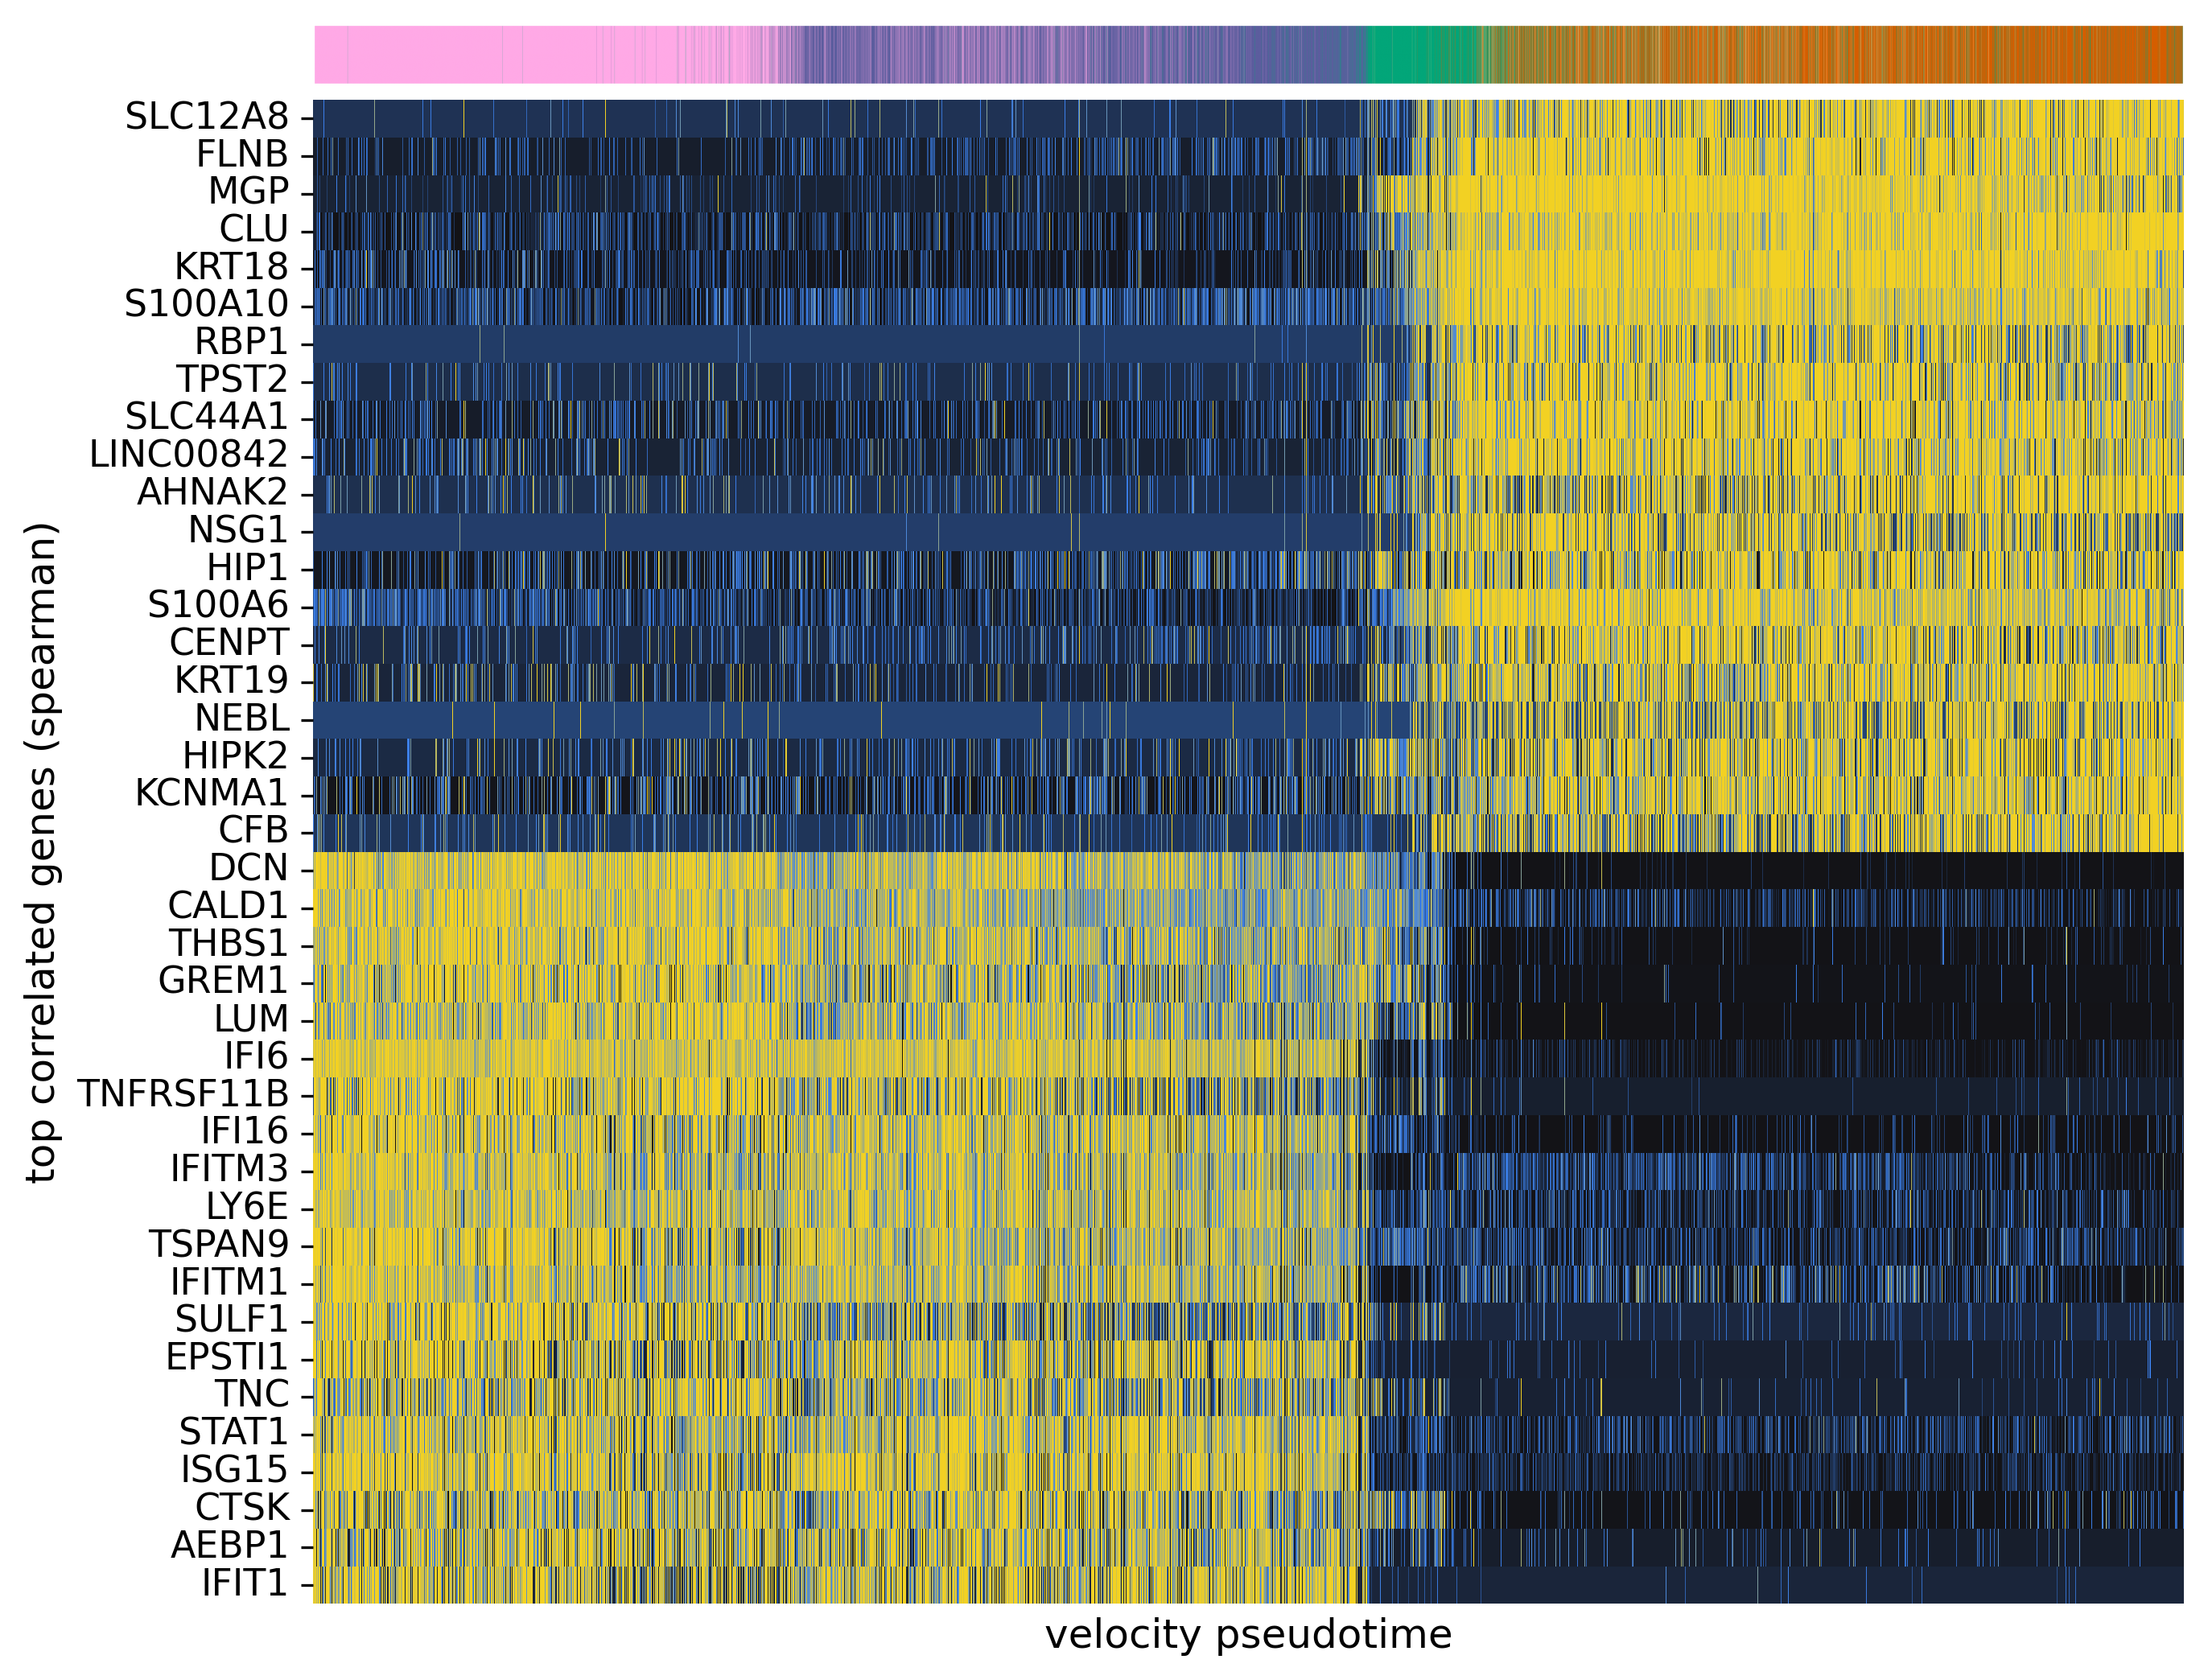

In [14]:
# get top correlated genes
top_n_genes = 20

top_pos = cors_df2.sort_values(by='correlation', ascending=False)['gene'].head(top_n_genes).tolist()
top_neg = cors_df2.sort_values(by='correlation', ascending=True)['gene'].head(top_n_genes).tolist()
selected_genes = top_pos + top_neg


cell_order = gdata.obs.sort_values("mean_velocity_pseudotime").index
n_cells = len(cell_order)

gdata.X = gdata.layers['log_norm'].copy()

expr = gdata[cell_order, selected_genes].X
if not isinstance(expr, np.ndarray):
    expr = expr.toarray()

# z-score expression
expr_z = zscore(expr, axis=0)

# get bar for cluster order
clusters = gdata.obs.loc[cell_order, 'cluster']

# mapping: category → color
cluster_colors = dict(zip(
    gdata.obs['cluster'].cat.categories,
    gdata.uns['cluster_colors']
))

# convert cluster labels to colors for each cell in order
col_colors = clusters.map(cluster_colors).to_numpy()
rgba_colors = np.array([to_rgba(c) for c in col_colors])


fig = plt.figure(figsize=(10, 8.5), dpi=300)

gs = gridspec.GridSpec(
    2, 1, 
    height_ratios=[0.4, 10],   # small top bar, big heatmap
    hspace=0.02                 # small spacing
)

# --- Top colorbar axis (tiny horizontal strip) ---
ax_color = fig.add_subplot(gs[0])

ax_color.imshow(rgba_colors[np.newaxis, :, :], aspect='auto')
ax_color.set_xlim(0, n_cells)
ax_color.set_xticks([])
ax_color.set_yticks([])
for spine in ax_color.spines.values():
    spine.set_edgecolor('white')

ax_heat = fig.add_subplot(gs[1])

sns.heatmap(
    expr_z.T,
    cmap=custom_cmap,
    xticklabels=False,
    yticklabels=selected_genes,
    vmin=-1.5,
    vmax=1.5,
    cbar=False,
    ax=ax_heat,
)
ax_heat.set_yticklabels(ax_heat.get_yticklabels(), fontsize=11)
ax_heat.set_xlabel("velocity pseudotime", fontsize=12)
ax_heat.set_ylabel("top correlated genes (spearman)", fontsize=12)

plt.tight_layout()
plt.show()

# enrichr

In [20]:
n_genes = 100

# df = cors_df.copy()
df = cors_df2.copy()

pos = df[df['correlation'] > 0].copy()
top_pos = pos.sort_values(by='correlation', ascending=False)['gene'].head(n_genes).tolist()
print(len(top_pos))

neg = df[df['correlation'] < 0].copy()
top_neg = neg.sort_values(by='correlation', ascending=True)['gene'].head(n_genes).tolist()
print(len(top_neg))

pd.set_option('display.max_colwidth', None)

# database = 'celltypes'
database = "GO_Biological_Process_2025"
# database="KEGG_2021_Human"
# database='MSigDB_Hallmark_2020' 
# database="Reactome_Pathways_2024"
# database = "CellMarker_2024"
# database='Tabula_Sapiens'


# ranking significance by n overlapping genes (proportion of total genes in that path)

edf_pos = gget.enrichr(top_pos, database=database, save=False)
edf_pos = edf_pos[edf_pos['adj_p_val'] < 0.05]
# edf_pos['n_overlap'] = (edf_pos['overlapping_genes'].str.strip('[]').str.split(',').apply(lambda x: len([g.strip() for g in x if g.strip()])))
edf_pos['n_overlap'] = edf_pos['overlapping_genes'].apply(len)
edf_pos = edf_pos.sort_values(by='combined_score', ascending=False)
display(edf_pos[['path_name', 'overlapping_genes', 'n_overlap', 'adj_p_val', 'combined_score']].head(15))
print("=" * 100 + "\n")

edf_neg = gget.enrichr(top_neg, database=database, save=False)
edf_neg = edf_neg[edf_neg['adj_p_val'] < 0.05]
edf_neg['n_overlap'] = edf_neg['overlapping_genes'].apply(len)
edf_neg = edf_neg.sort_values(by='combined_score', ascending=False)
display(edf_neg[['path_name', 'overlapping_genes', 'n_overlap', 'adj_p_val', 'combined_score']].head(15))
print("=" * 100 + "\n")

13:27:30 - INFO - Performing Enrichr analysis using database GO_Biological_Process_2025.
2025-12-12 13:27:30 | [INFO] Performing Enrichr analysis using database GO_Biological_Process_2025.


100
100


,path_name,overlapping_genes,n_overlap,adj_p_val,combined_score
8,Regulation of Plasma Membrane Repair (GO:1905684),"[ANXA2, S100A10]",2,0.023991,1125.317013
0,Positive Regulation of Protein Processing (GO:0010954),"[GSN, ANXA2, MELTF, S100A10]",4,0.002361,664.331377
9,Positive Regulation of Plasminogen Activation (GO:0010756),"[MELTF, S100A10]",2,0.045048,615.404316
2,Clathrin Coat Assembly (GO:0048268),"[HIP1, NSG1, GAS7]",3,0.011415,504.811350
12,Choline Transport (GO:0015871),"[SEC14L1, SLC44A1]",2,0.046053,493.565548
4,Regulation of Plasminogen Activation (GO:0010755),"[SERPINE1, MELTF, S100A10]",3,0.011415,456.304277
7,Negative Regulation of Peptidase Activity (GO:0010466),"[CSTB, SERPINE1, SERPINB6]",3,0.021995,261.879321
3,Positive Regulation of Receptor-Mediated Endocytosis (GO:0048260),"[HIP1, ANXA2, SERPINE1, CLU]",4,0.011415,205.404186
5,Regulation of Substrate Adhesion-Dependent Cell Spreading (GO:1900024),"[MELTF, EFNA5, PTK2, S100A10]",4,0.017983,153.871026
1,Positive Regulation of Cellular Component Organization (GO:0051130),"[AHNAK, ANXA2, ASAP1, CLU, TRABD2B, S100A10]",6,0.008768,130.256620


13:27:30 - INFO - Performing Enrichr analysis using database GO_Biological_Process_2025.
2025-12-12 13:27:30 | [INFO] Performing Enrichr analysis using database GO_Biological_Process_2025.


,path_name,overlapping_genes,n_overlap,adj_p_val,combined_score
5,Response to Interferon-Beta (GO:0035456),"[IFITM3, IFITM1, PLSCR1, IFITM2, IFI16, STAT1, XAF1]",7,1.783624e-08,1573.121145
2,Negative Regulation of Viral Genome Replication (GO:0045071),"[IFITM3, IFITM1, PLSCR1, IFITM2, IFI16, MX1, EIF2AK2, ISG15, IFIT1]",9,7.646637e-10,1358.564957
7,Response to Interferon-Alpha (GO:0035455),"[IFITM3, IFITM1, IFITM2, MX2, EIF2AK2]",5,4.617386e-06,1292.373811
19,Response to Type I Interferon (GO:0034340),"[MX1, ISG15, IFIT1]",3,5.925807e-04,1180.940558
40,Leukocyte Chemotaxis Involved in Inflammatory Response (GO:0002232),"[MDK, PTN]",2,7.107528e-03,1125.317013
1,Negative Regulation of Viral Process (GO:0048525),"[IFITM3, IFITM1, PLSCR1, IFITM2, IFI16, STAT1, MX1, EIF2AK2, ISG15, IFIT1]",10,6.126364e-10,1086.733441
4,Regulation of Viral Genome Replication (GO:0045069),"[IFITM3, IFITM1, PLSCR1, IFITM2, IFI16, MX1, EIF2AK2, ISG15, IFIT1]",9,9.405099e-09,824.710559
47,Interleukin-27-Mediated Signaling Pathway (GO:0070106),"[STAT1, MX1]",2,9.076830e-03,803.117991
46,Dendrite Arborization (GO:0140059),"[NRP1, PTN]",2,9.076830e-03,803.117991
45,Regulation of Hepatocyte Proliferation (GO:2000345),"[MDK, PTN]",2,9.076830e-03,803.117991


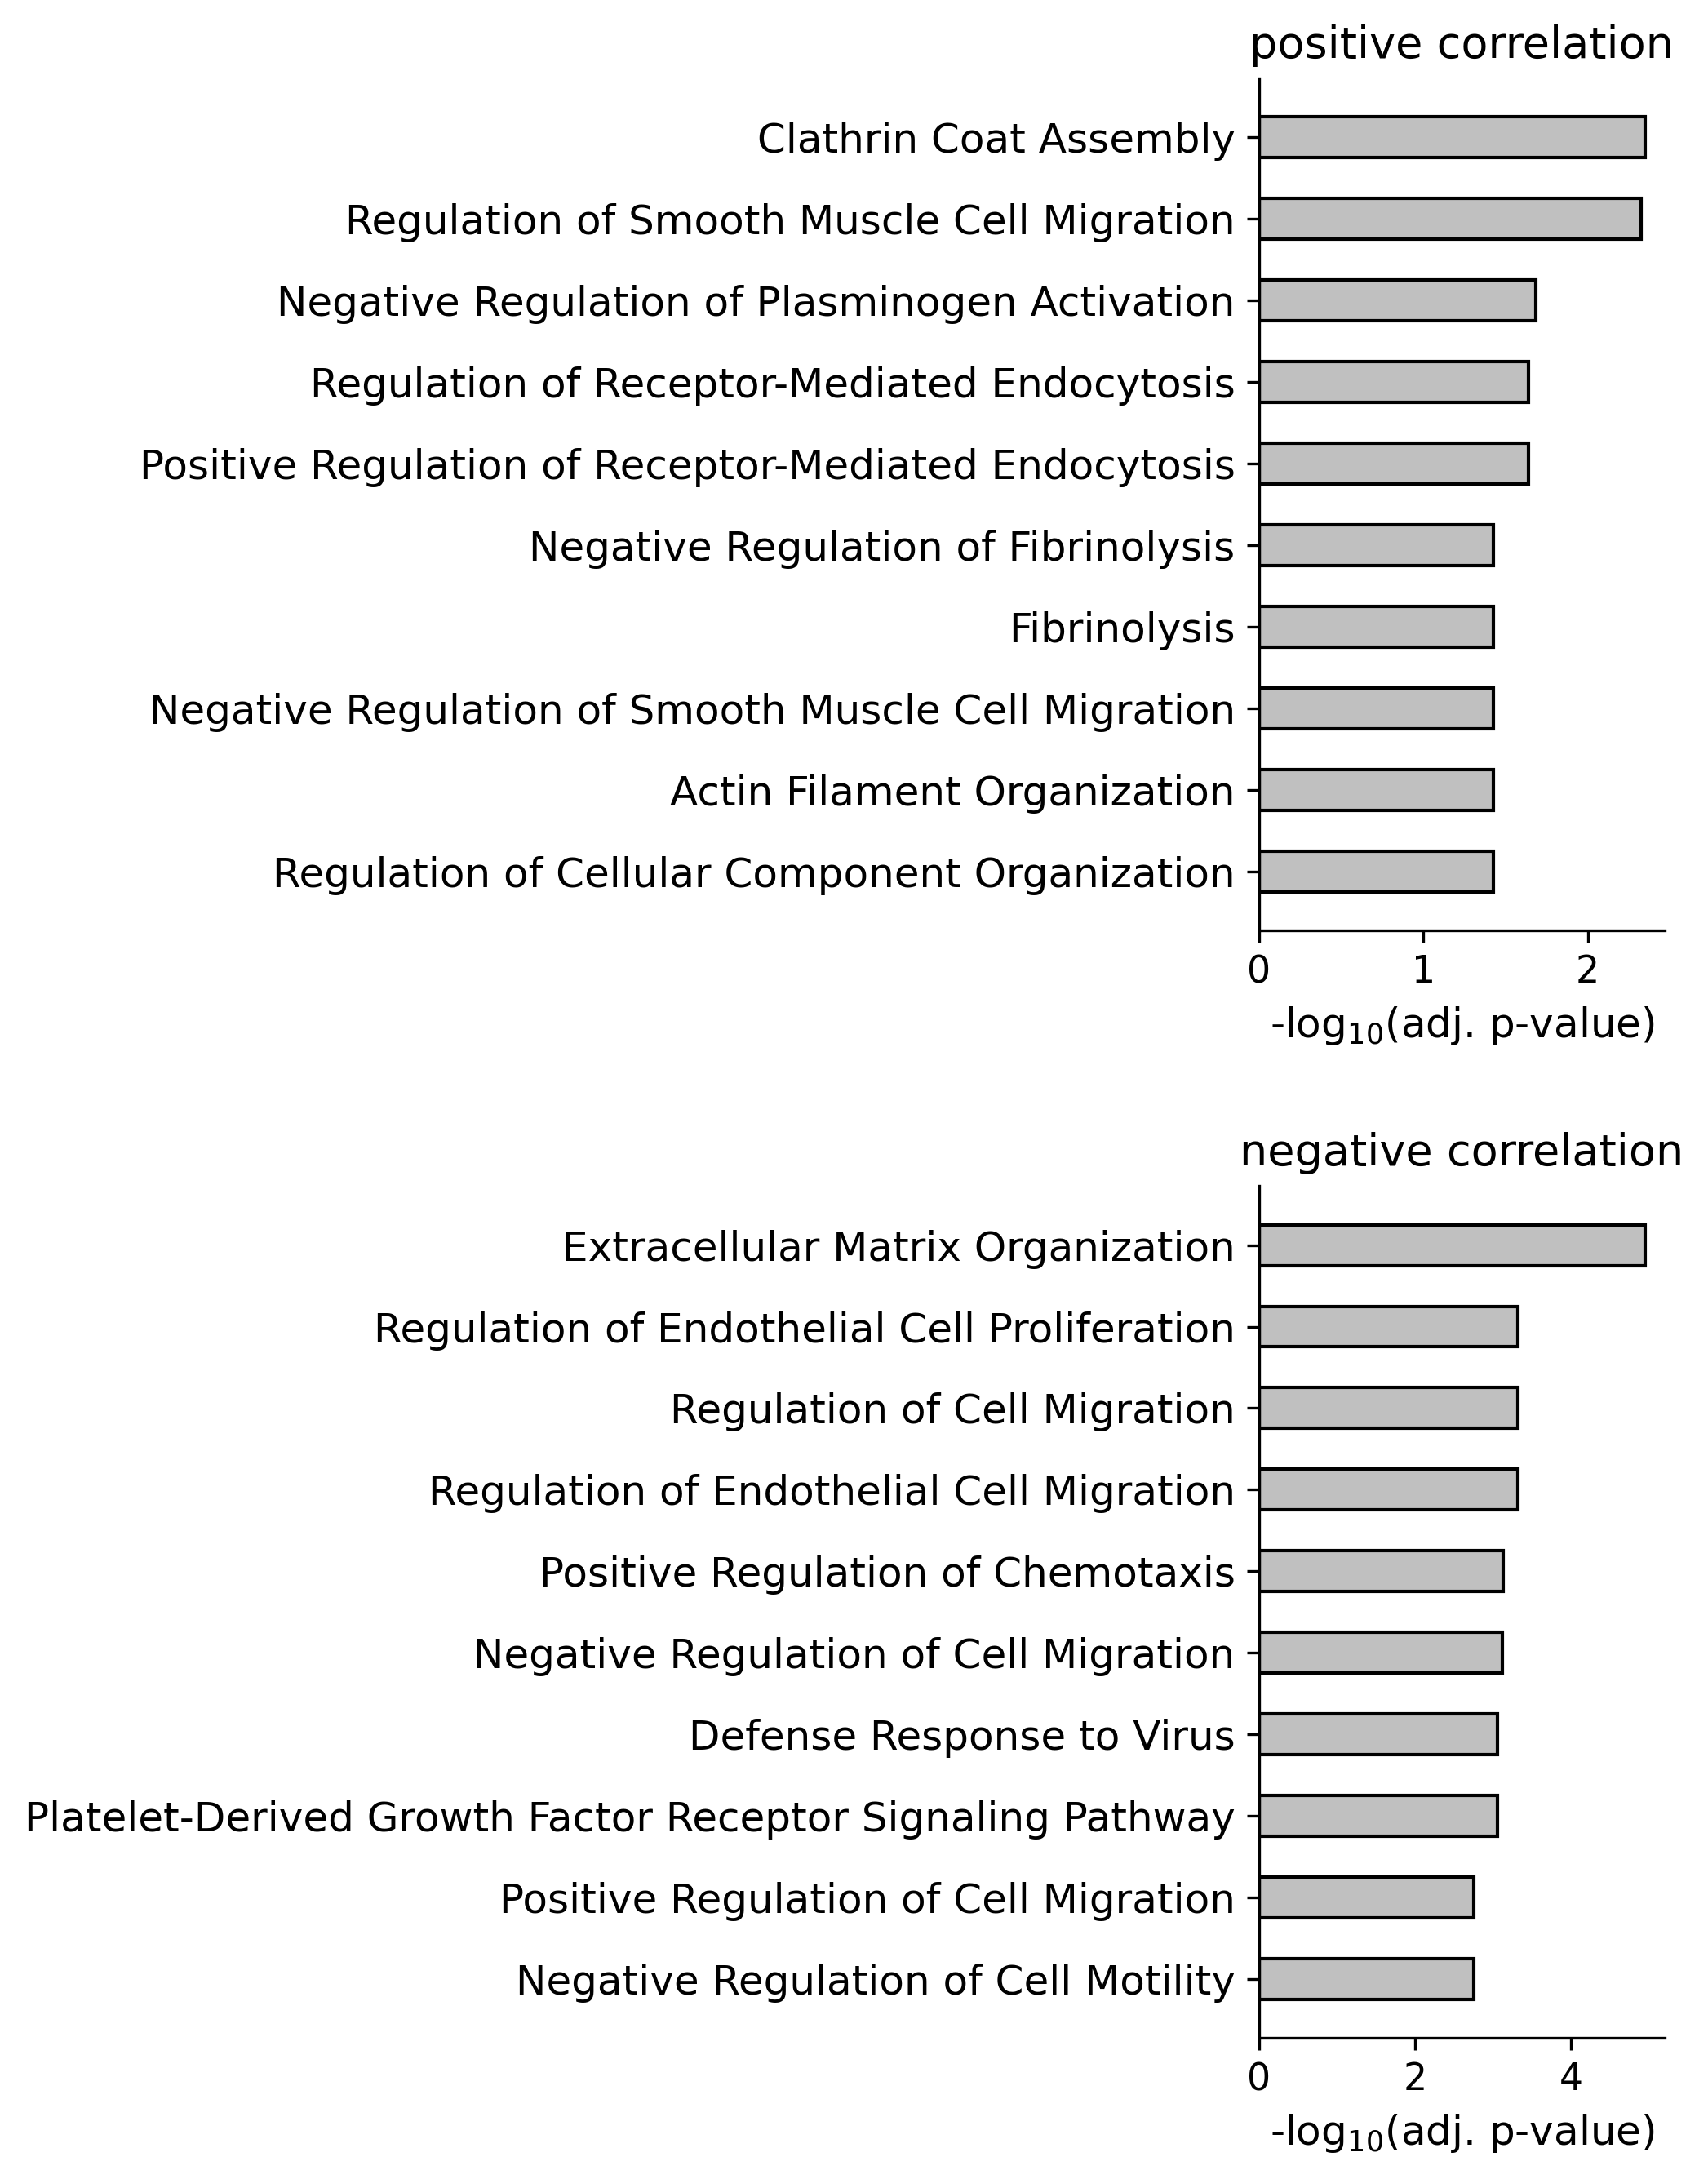

In [44]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 9 #15, 4
fig, axes = plt.subplots(2, 1)
axes = axes.flatten()

n_terms = 10

groups = ['positive correlation', 'negative correlation']

for i, group in enumerate(groups):
    
    if group == 'positive correlation':
        tmp = edf_pos.copy()
    else:
        tmp = edf_neg.copy()
        
    top_terms = tmp[['path_name', 'adj_p_val', 'overlapping_genes']].head(n_terms).copy()

    # Remove IDs in parentheses from path names
    top_terms['path_name'] = top_terms['path_name'].apply(lambda x: re.sub(r"\s*\(.*\)", "", x))
    top_terms['neglog10_p'] = -np.log10(top_terms['adj_p_val'])

    colors = ["silver" if p <= 0.05 else "lemonchiffon" for p in top_terms['adj_p_val']]

    ax = axes[i]
    ax.barh(
        top_terms['path_name'][::-1],
        top_terms['neglog10_p'][::-1],
        color=colors[::-1],
        height=0.5,
        edgecolor='k',
        linewidth=1,
    )

    ax.set_title(f"{group}", fontsize=13)
    ax.set_xlabel("-log$_{10}$(adj. p-value)", fontsize=12)
    ax.set_ylabel("")  
    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

In [48]:
for clust in ['R1', 'R2', 'R3']:
    mask = adata.obs['cluster'] == clust   # 'cluster' is your annotation column

    # Step 2: Get velocity values for these cells
    velocities = adata[mask].layers['velocity']  # shape: (cells_in_clust, genes)

    # Step 3: Average velocity per gene in cluster
    mean_vel_per_gene = velocities.mean(axis=0)

    # Step 4: Get gene names
    gene_names = adata.var_names

    # Step 5: Rank genes by mean velocity (descending)
    top_genes = gene_names[np.argsort(mean_vel_per_gene)[::-1][:20]]

    print(f"Top 20 upregulated velocity genes in {clust}:")
    print(top_genes)

Top 20 upregulated velocity genes in R1:
Index(['MALAT1', 'OOEP', 'PLEKHA7', 'RBFOX2', 'STEAP1B', 'ENSG00000257322',
       'H2AJ', 'ACTB', 'ENSG00000290018', 'IFITM2', 'SERPINH1', 'CAPNS1',
       'AMBRA1', 'CLIC4', 'LIMA1', 'GPS2', 'ENSG00000235979', 'NEAT1', 'B2M',
       'FLNA'],
      dtype='object')
Top 20 upregulated velocity genes in R2:
Index(['MALAT1', 'OOEP', 'PLEKHA7', 'STEAP1B', 'ENSG00000257322', 'MAGI1',
       'KCNMA1', 'SERPINE1', 'MIR4435-2HG', 'ENSG00000290018', 'NEAT1',
       'MAGI2', 'MORC3', 'FTX', 'IGFL2-AS1', 'IFITM2', 'LINC-PINT', 'CAMK2D',
       'PVT1', 'HIP1'],
      dtype='object')
Top 20 upregulated velocity genes in R3:
Index(['MALAT1', 'OOEP', 'PLEKHA7', 'STEAP1B', 'ENSG00000257322', 'APOLD1',
       'SMYD3', 'ENSG00000290018', 'MAGI1', 'KCNMA1', 'MIR4435-2HG', 'SLC35F3',
       'PBX3', 'MORC3', 'HIP1', 'ENSG00000279168', 'SCLT1', 'DLEU2', 'PVT1',
       'LINC01572'],
      dtype='object')


In [50]:
for clust in ['R1', 'R2', 'R3']:
    mask = adata.obs['cluster'] == clust
    v_all = adata.layers['velocity']           # shape: cells x genes
    v_clust = adata[mask].layers['velocity']

    mean_v_all = np.mean(v_all, axis=0)
    std_v_all = np.std(v_all, axis=0)
    mean_v_clust = np.mean(v_clust, axis=0)
    
    # Avoid division by zero
    std_v_all[std_v_all == 0] = 1e-6

    # Z-score
    z_scores = (mean_v_clust - mean_v_all) / std_v_all
    
    gene_names = np.array(adata.var_names)
    top_z_genes = gene_names[np.argsort(z_scores)[::-1][:20]]
    print(f"Top 20 upregulated velocity genes in {clust} (by z-score):")
    print(top_z_genes)

Top 20 upregulated velocity genes in R1 (by z-score):
['CALR' 'SERPINH1' 'CAPNS1' 'CLIC4' 'ENSG00000257322' 'PLOD1' 'CTTN'
 'SERPINE2' 'GPX1' 'HPS1' 'MMP24OS' 'ITM2B' 'KIZ-AS1' 'TRIM16'
 'ENSG00000254343' 'MGP' 'TPM4' 'CLU' 'LINC01500' 'MICAL2']
Top 20 upregulated velocity genes in R2 (by z-score):
['ENSG00000276850' 'C2' 'MAGI1' 'C16orf74' 'ABTB2' 'KCNMA1' 'RHBDL2'
 'LRRFIP1' 'ENSG00000271945' 'COL1A2' 'SMCHD1' 'LARGE1' 'PCA3'
 'ENSG00000232633' 'SH3PXD2B' 'ENSG00000267922' 'CHAF1B' 'CENPT'
 'ENSG00000266049' 'MMP28']
Top 20 upregulated velocity genes in R3 (by z-score):
['ENSG00000249084' 'ANLN' 'KIF4A' 'NOSTRIN' 'RACGAP1' 'TPX2' 'NDC80'
 'MELK' 'CIT' 'ARHGAP11B' 'KIF2C' 'KIF20B' 'ECT2' 'CENPF' 'NUF2'
 'DIAPH3-AS1' 'HCCS-DT' 'ENSG00000287937' 'SCG5' 'CKAP2']


In [61]:
from scipy import sparse
# Helper to safely extract dense arrays from layers
def get_layer_dense(adata, mask, layername):
    # Subset AnnData
    X = adata[mask].layers[layername]
    # If sparse, convert to dense
    if sparse.issparse(X):
        X = X.toarray()
    return X

# Masks for groups
early_mask = (adata.obs['cluster'].isin(['C4', 'C5']))
late_mask  = adata.obs['cluster'].isin(['R1', 'R2', 'R3'])

# Print # of early/late cells to confirm selection
print("Early cells:", np.sum(early_mask))
print("Late cells:", np.sum(late_mask))

spliced_early = get_layer_dense(adata, early_mask, 'spliced')
spliced_late  = get_layer_dense(adata, late_mask,  'spliced')

print("spliced_early shape:", spliced_early.shape)  # should be (n_cells, n_genes)
print("spliced_late shape:",  spliced_late.shape)

mean_spliced_early = np.mean(spliced_early, axis=0).flatten()
mean_spliced_late  = np.mean(spliced_late,  axis=0).flatten()

vel_early = get_layer_dense(adata, early_mask, 'velocity')
vel_late  = get_layer_dense(adata, late_mask,  'velocity')

mean_vel_early = np.mean(vel_early, axis=0).flatten()
mean_vel_late  = np.mean(vel_late,  axis=0).flatten()

gene_names = np.array(adata.var_names).flatten()

# Differences
diff_spliced_late = mean_spliced_late - mean_spliced_early
diff_spliced_early = mean_spliced_early - mean_spliced_late
diff_vel_late = mean_vel_late - mean_vel_early
diff_vel_early = mean_vel_early - mean_vel_late

# Top genes
top_late_spliced_idx = np.argsort(diff_spliced_late)[::-1][:20]
top_early_spliced_idx = np.argsort(diff_spliced_early)[::-1][:20]
top_late_velocity_idx = np.argsort(diff_vel_late)[::-1][:20]
top_early_velocity_idx = np.argsort(diff_vel_early)[::-1][:20]

top_late_spliced = gene_names[top_late_spliced_idx].tolist()
top_early_spliced = gene_names[top_early_spliced_idx].tolist()
top_late_velocity = gene_names[top_late_velocity_idx].tolist()
top_early_velocity = gene_names[top_early_velocity_idx].tolist()

print("\nTop 20 spliced genes upregulated in late (reprogrammed) cells:")
print(top_late_spliced)
print("\nTop 20 velocity genes upregulated in late (reprogrammed) cells:")
print(top_late_velocity)
print("\nTop 20 spliced genes upregulated in early (control) cells:")
print(top_early_spliced)
print("\nTop 20 velocity genes upregulated in early (control) cells:")
print(top_early_velocity)

Early cells: 8464
Late cells: 6853
spliced_early shape: (8464, 23434)
spliced_late shape: (6853, 23434)

Top 20 spliced genes upregulated in late (reprogrammed) cells:
['FTL', 'NEAT1', 'MT2A', 'TIMP1', 'TMSB10', 'SPARC', 'IGFBP6', 'ENSG00000291105', 'SERPINE1', 'RPS18', 'SH3BGRL3', 'PSAP', 'PRDX5', 'RPL35A', 'KRT18', 'COL1A1', 'RPL34', 'MT1E', 'NME2', 'RPS27A']

Top 20 velocity genes upregulated in late (reprogrammed) cells:
['ENSG00000257322', 'SERPINE1', 'MORC3', 'KCNMA1', 'CLIC4', 'MAGI1', 'CAPNS1', 'NEAT1', 'COL1A2', 'EEF2', 'IGFL2-AS1', 'HIP1', 'DOCK5', 'CENPT', 'SLC35F3', 'PVT1', 'SERPINH1', 'NFAT5', 'MIR4435-2HG', 'ENSG00000276850']

Top 20 spliced genes upregulated in early (control) cells:
['ISG15', 'VIM', 'RPL28', 'TMSB4X', 'LGALS1', 'THBS1', 'IGFBP5', 'RPL37A', 'TPM4', 'RPL31', 'RPLP2', 'RPL23A', 'TAGLN', 'SERPINE2', 'COL1A2', 'TNFRSF11B', 'HSP90B1', 'C12orf75', 'CCL2', 'RPS12']

Top 20 velocity genes upregulated in early (control) cells:
['MALAT1', 'ENSG00000280441', 'RBFOX

In [21]:
n_genes = 100
n_cells_by_counts = 200
df = adata.var.sort_values(by='fit_likelihood', ascending=False).copy()
df = df[df['n_cells_by_counts'] > n_cells_by_counts]

columns = [
    'mean_counts',
    'fit_beta', 
    'fit_gamma', 
    'fit_scaling', 
    'fit_likelihood', 
    'fit_pval_steady',
    'velocity_gamma',
    'velocity_qreg_ratio',
    'velocity_r2'
]

print(df[columns].head().to_string())

           mean_counts  fit_beta  fit_gamma  fit_scaling  fit_likelihood  fit_pval_steady  velocity_gamma  velocity_qreg_ratio  velocity_r2
FLNB          2.754787  1.756608   0.679633     0.219159        0.546637         0.484433        0.390343             0.435144     0.878381
LINC00842     1.636748  0.794225   0.387575     0.273095        0.510045         0.476171        0.446722             0.554477     0.885442
TOP2A         3.908573  0.255986   0.183766     0.450219        0.503081         0.448094        0.895199             0.886962     0.891502
NEAT1        22.250859  9.299254   0.448618     0.021788        0.498124         0.499017        0.025985             0.033244     0.409295
CALD1        15.338211  0.883958   0.635053     0.366635        0.481113         0.482574        0.743205             0.755055     0.880575


13:31:42 - INFO - Performing Enrichr analysis using database GO_Biological_Process_2025.
2025-12-12 13:31:42 | [INFO] Performing Enrichr analysis using database GO_Biological_Process_2025.


                                              clean_path  adj_p_val                       genes
                                  DNA Topological Change   0.000060           TOP2A,HMGB2,HMGB1
                                 DNA Conformation Change   0.000241           TOP2A,HMGB2,HMGB1
                 Cellular Response to Lipopolysaccharide   0.002298      MMP3,HMGB2,IRAK3,HMGB1
                                    DNA Geometric Change   0.003256                 HMGB2,HMGB1
                          Response to Lipopolysaccharide   0.003722      MMP3,HMGB2,IRAK3,HMGB1
                                     V(D)J Recombination   0.006795                 HMGB2,HMGB1
       Cellular Response to Molecule of Bacterial Origin   0.028036            MMP3,HMGB2,HMGB1
                                 Chromosome Condensation   0.035388                  TOP2A,SMC4
                            Sister Chromatid Segregation   0.042455                  TOP2A,SMC4
Double-Strand Break Repair via Nonhomolo

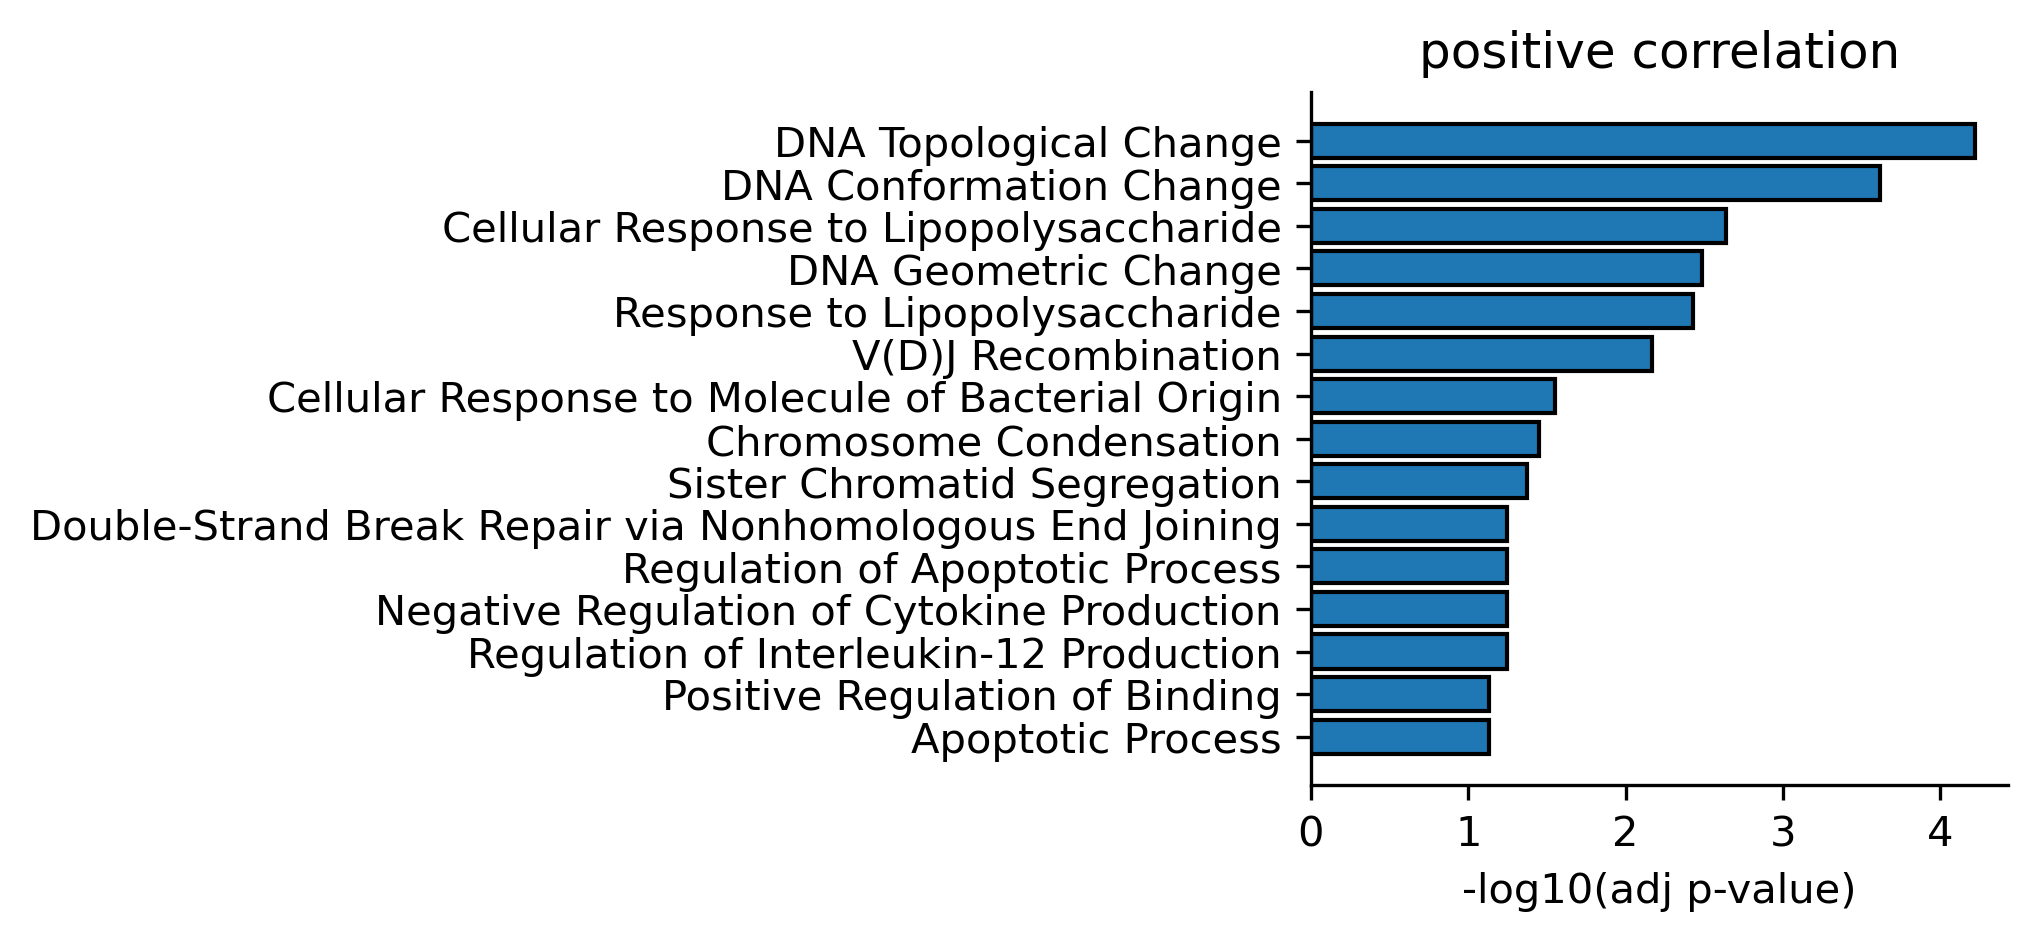

In [22]:
n = 25
alpha = 0.05
n_show = 15
database = 'GO_Biological_Process_2025'
top_n = df.nlargest(n, 'velocity_r2')

edf = gget.enrichr(top_n.index, database=database, save=False)
edf['genes'] = edf['overlapping_genes'].apply(lambda x: ",".join(x))
edf['clean_path'] = edf['path_name'].str.replace(r'\s*\(GO:\d+\)', '', regex=True)
print(edf[['clean_path', 'adj_p_val', 'genes',]].head(n_show).to_string(index=False))
                                                               
plot_df = edf.head(n_show)

# Pl24
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.barh(plot_df['clean_path'], -np.log10(plot_df['adj_p_val']), ec='k')
plt.xlabel('-log10(adj p-value)')
plt.gca().invert_yaxis()
plt.title('positive correlation')
sns.despine()
plt.show()

13:32:54 - INFO - Performing Enrichr analysis using database GO_Biological_Process_2025.
2025-12-12 13:32:54 | [INFO] Performing Enrichr analysis using database GO_Biological_Process_2025.


                                                             clean_path  adj_p_val                                         genes
                                                            Translation   0.118682 MRPL41,RPL12,RPL14,RPL23A,CHCHD1,UBA52,MRPL54
                                     Macromolecule Biosynthetic Process   0.134677         MRPL41,DDX18,RPL12,RPL14,RPL23A,UBA52
                                     Peptidyl-Threonine Phosphorylation   0.183594                             CAMK2D,CSNK2B,NLK
                                        Peptidyl-Threonine Modification   0.237691                             CAMK2D,CSNK2B,NLK
                                                Cytoplasmic Translation   0.237691                      RPL12,RPL14,RPL23A,UBA52
                                     COPII-coated Vesicle Cargo Loading   0.253112                                   RAB1A,SEC13
                                                        Gene Expression   0.253112   MRPL41,RPL12

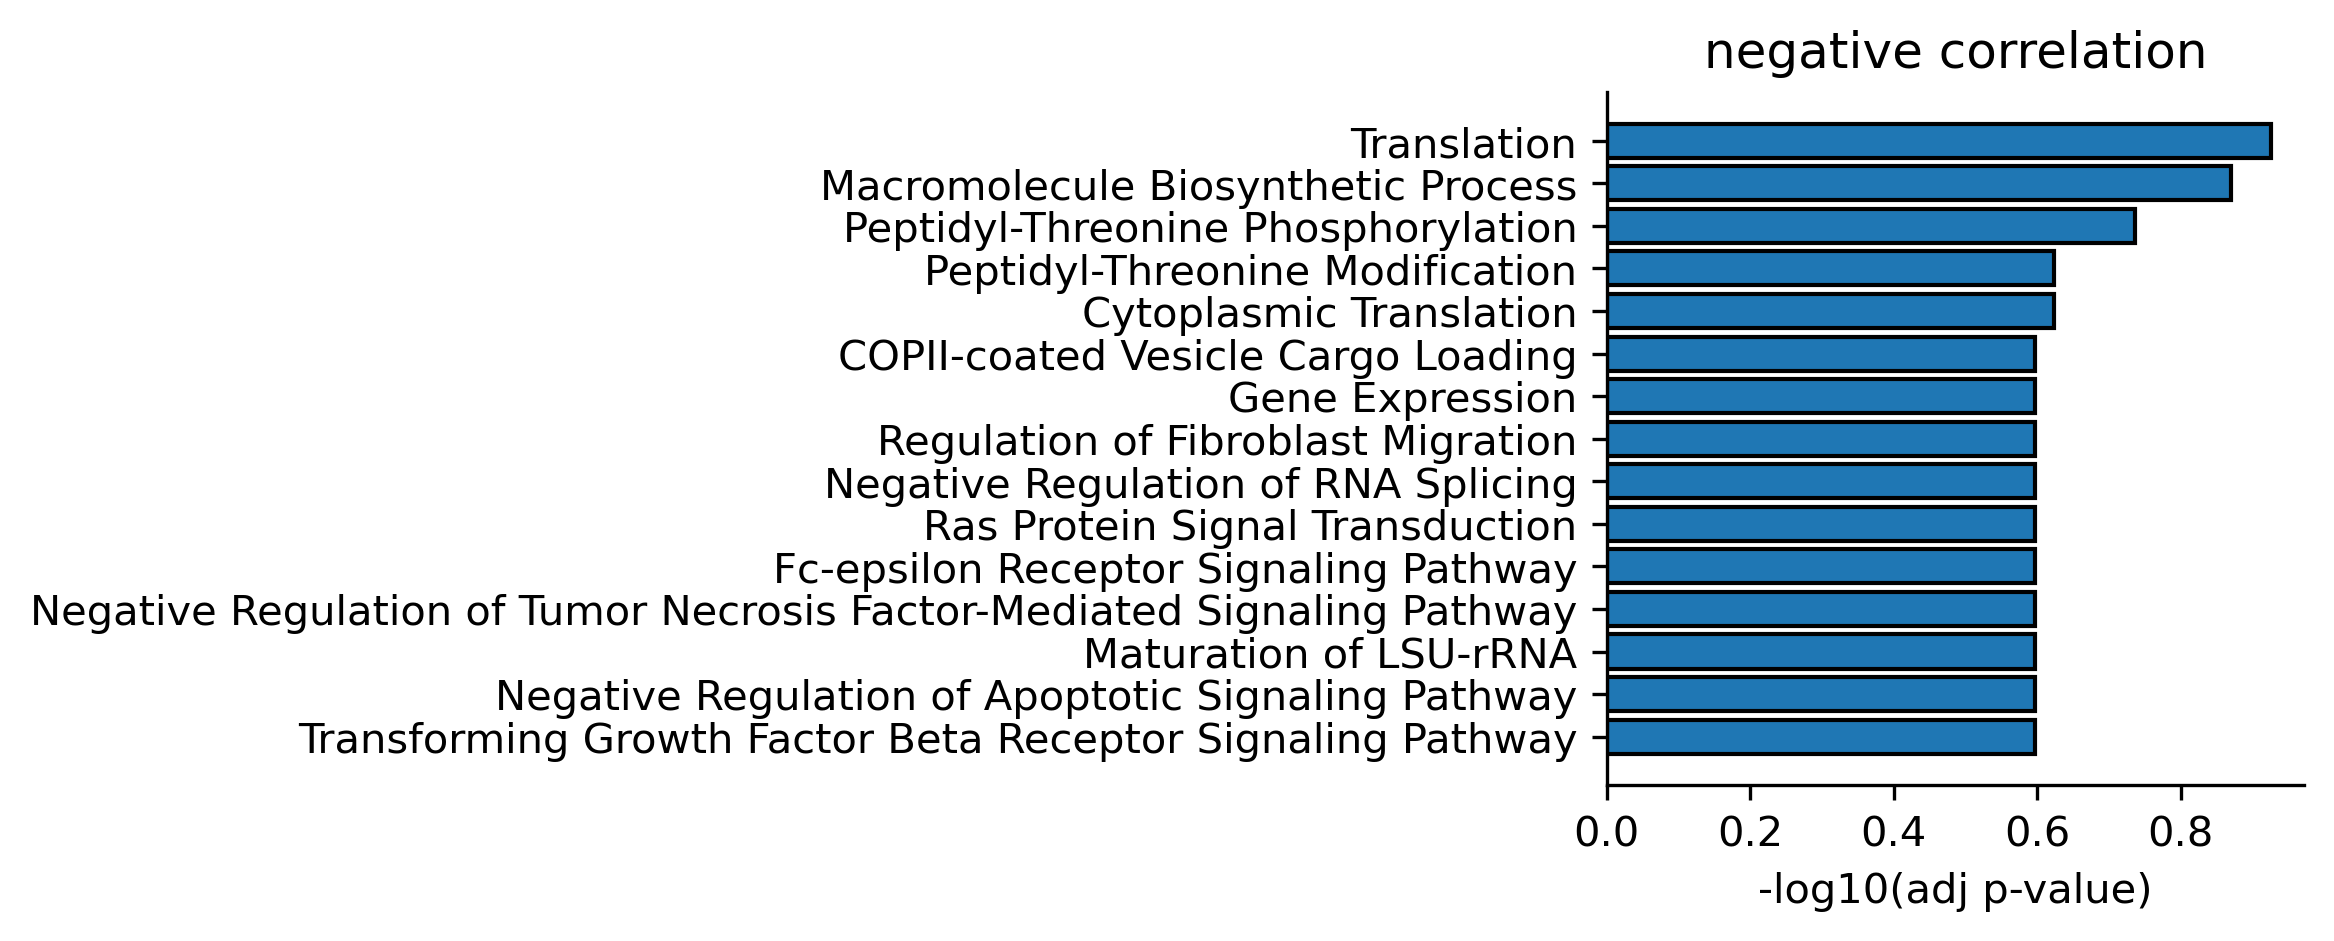

In [25]:
n = 100
alpha = 0.05
n_show = 15
database = 'GO_Biological_Process_2025'
top_n = df.nsmallest(n, 'velocity_r2')

edf = gget.enrichr(top_n.index, database=database, save=False)
edf['genes'] = edf['overlapping_genes'].apply(lambda x: ",".join(x))
edf['clean_path'] = edf['path_name'].str.replace(r'\s*\(GO:\d+\)', '', regex=True)
print(edf[['clean_path', 'adj_p_val', 'genes',]].head(n_show).to_string(index=False))
                                                               
plot_df = edf.head(n_show)

# Pl24
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.barh(plot_df['clean_path'], -np.log10(plot_df['adj_p_val']), ec='k')
plt.xlabel('-log10(adj p-value)')
plt.gca().invert_yaxis()
plt.title('negative correlation')
sns.despine()
plt.show()